In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from aux_functions import split_data
from sklearn.preprocessing import LabelEncoder
import torch.optim as optim
import torch.nn as nn
import torch
import tqdm as tqdm
from sklearn.decomposition import PCA

In [38]:
df = pd.read_csv('data/preprocessed/BPI_Challenge_2012.csv')

In [39]:
# Removing the sequences with length of more than 50
df = df[df['case:concept:name'].isin(df.groupby('case:concept:name').size()[df.groupby('case:concept:name').size() < 50].index)]

In [40]:
encoder = LabelEncoder()

# Fit and transform the 'concept:name' column
encoded_concept_names = encoder.fit_transform(df['concept:name'])
# Adjusting labels to start from 1 instead of 0
encoded_concept_names += 1

# Fit and transform the 'next_concept:name' column
encoded_next_concept_names = encoder.fit_transform(df['next_concept:name'])
# Adjusting labels to start from 1 instead of 0
encoded_next_concept_names += 1

# Assign the encoded values back to the DataFrame
df['int:concept:name'] = encoded_concept_names
df['int:next_concept:name'] = encoded_next_concept_names

In [41]:
df.head()

,org:resource,lifecycle:transition,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ,position,next_concept:name,next_timestamp,int:concept:name,int:next_concept:name
0,112.0,COMPLETE,A_SUBMITTED,2011-10-01 00:38:44.546000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000,1,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880000+00:00,10,7
1,112.0,COMPLETE,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000,2,A_PREACCEPTED,2011-10-01 00:39:37.906000+00:00,7,8
2,112.0,COMPLETE,A_PREACCEPTED,2011-10-01 00:39:37.906000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000,3,W_Completeren aanvraag,2011-10-01 00:39:38.875000+00:00,8,20
3,112.0,SCHEDULE,W_Completeren aanvraag,2011-10-01 00:39:38.875000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000,4,W_Completeren aanvraag,2011-10-01 11:36:46.437000+00:00,20,20
4,112.0,COMPLETE,A_SUBMITTED,2011-10-01 08:08:58.256000+00:00,2011-10-01 08:08:58.256000+00:00,173691,5000,1,A_PARTLYSUBMITTED,2011-10-01 08:09:02.195000+00:00,10,7


In [42]:
columns_to_keep = ['int:concept:name', 'case:concept:name', 'position','int:next_concept:name']
df = df[columns_to_keep]
df.head()

,int:concept:name,case:concept:name,position,int:next_concept:name
0,10,173688,1,7
1,7,173688,2,8
2,8,173688,3,20
3,20,173688,4,20
4,10,173691,1,7


In [43]:
train, test = split_data(df, 0.8)

Original size: 189269
Train size: 137633
Test size: 30467
Ratio: 0.8187566924449732
Dropped cases in both sets: 647
Dropped rows from dataset: 21169


In [44]:
train.head()

,int:concept:name,case:concept:name,position,int:next_concept:name
0,10,173688,1,7
1,7,173688,2,8
2,8,173688,3,20
3,20,173688,4,20
4,10,173691,1,7


In [45]:
# Generating all the possible prefixes and suffixes of different length in the train set
prefixes = []
suffixes = []
for case in train['case:concept:name'].unique():
    case_df = train[train['case:concept:name'] == case]
    for i in range(1, len(case_df)):
        prefixes.append(case_df.iloc[:i].values)
        suffixes.append(list(case_df.iloc[i:]['int:concept:name'].values))

In [46]:
# Generating all the possible prefixes and suffixes of different length in the test set
prefixes_test = []
suffixes_test = []
for case in test['case:concept:name'].unique():
    case_df = test[test['case:concept:name'] == case]
    for i in range(1, len(case_df)):
        prefixes_test.append(case_df.iloc[:i].values)
        suffixes_test.append(list(case_df.iloc[i:]['int:concept:name'].values))

In [47]:
# Add padding to the prefix nd suffix to make every sequence of the same length (the length of the longest sequence) TRAIN
# We add the padding before the sequence in prefixes and after the sequence in suffixes
max_length = df['case:concept:name'].value_counts().max()
padding_dim = len(prefixes[0][0])
for i in range(len(prefixes)):
    padding_prefix = np.zeros((max_length - len(prefixes[i]), padding_dim))
    padding_suffix = [0] * (max_length - len(suffixes[i]))
    prefixes[i] = np.concatenate([padding_prefix, prefixes[i]], axis=0)
    suffixes[i] = np.concatenate([suffixes[i], padding_suffix], axis=0)

In [48]:
# Add padding to the prefix nd suffix to make every sequence of the same length (the length of the longest sequence) TEST
# We add the padding before the sequence in prefixes and after the sequence in suffixes
max_length = df['case:concept:name'].value_counts().max()
padding_dim = len(prefixes_test[0][0])
for i in range(len(prefixes_test)):
    padding_prefix = np.zeros((max_length - len(prefixes_test[i]), padding_dim))
    padding_suffix = [0] * (max_length - len(suffixes_test[i]))
    prefixes_test[i] = np.concatenate([padding_prefix, prefixes_test[i]], axis=0)
    suffixes_test[i] = np.concatenate([suffixes_test[i], padding_suffix], axis=0)

In [49]:
class LSDM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSDM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n.squeeze(0))
        return out

In [50]:
# Define the dimensions
input_dim = len(prefixes[0][0])  
hidden_dim = 64  
output_dim = len(suffixes[0])  

In [61]:
# Initialize the model
model = LSDM(input_dim, hidden_dim, output_dim)

In [62]:
prefixes_array = np.array(prefixes, dtype=np.float32)

In [63]:
# Convert data to PyTorch tensors
prefixes_tensor = torch.tensor(prefixes_array, dtype=torch.float32)
suffixes_tensor = torch.tensor(suffixes, dtype=torch.float32)

In [64]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [20]:
# choosing random index from the training set for prefix and suffix
nr = 20000

indices = np.random.choice(len(prefixes_tensor), nr, replace=False)
prefixes_tensor = prefixes_tensor[indices]
suffixes_tensor = suffixes_tensor[indices]

In [65]:
# Train the model
num_epochs = 10  
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(prefixes_tensor)
    loss = criterion(outputs, suffixes_tensor)
    loss.backward()
    optimizer.step()
    
    # Update the progress bar
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 102.2620
Epoch [2/10], Loss: 100.6635
Epoch [3/10], Loss: 99.0441
Epoch [4/10], Loss: 97.1870
Epoch [5/10], Loss: 94.6997
Epoch [6/10], Loss: 92.4473
Epoch [7/10], Loss: 90.3308


In [56]:
prefixes_array_test = np.array(prefixes_test, dtype=np.float32)

In [57]:
# Convert data to PyTorch tensors
prefixes_test_tensor = torch.tensor(prefixes_array_test, dtype=torch.float32)
suffixes_test_tensor = torch.tensor(suffixes_test, dtype=torch.float32)

In [24]:
# choosing 500 random index from the test set for prefix and suffix
indices = np.random.choice(len(prefixes_test_tensor), 500, replace=False)
prefixes_test_tensor = prefixes_test_tensor[indices]
suffixes_test_tensor = suffixes_test_tensor[indices]

In [58]:
# Set the model to evaluation mode
model.eval()

# Run the test data through the model
with torch.no_grad():
    test_outputs = model(prefixes_test_tensor)
    test_loss = criterion(test_outputs, suffixes_test_tensor)

print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 98.6042


In [59]:
test_outputs[0]

tensor([ 0.0465,  0.5284, -0.1307,  0.3941,  0.0530,  0.2033,  0.2470,  0.3656,
        -0.0095,  0.2798,  0.3342, -0.3009,  0.1436,  0.5425, -0.0419, -0.0944,
         0.2524, -0.4799,  0.2196,  0.0043,  0.1589,  0.0708, -0.1666,  0.3103,
         0.3014,  0.0726,  0.2342, -0.2479,  0.0186, -0.0561, -0.3284, -0.1079,
         0.1096,  0.3358,  0.3075, -0.3311,  0.2057,  0.0297,  0.1145, -0.1634,
         0.2706,  0.0905, -0.0461, -0.2444, -0.1352,  0.2445,  0.1020,  0.0734,
         0.1531])

<AxesSubplot: >

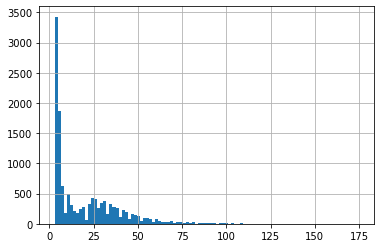

In [30]:
df.groupby('case:concept:name').size().sort_values(ascending=False)
# plotting frequency of the number of events in each case
df.groupby('case:concept:name').size().hist(bins=100)
